<a href="https://colab.research.google.com/github/3catz/finance/blob/master/stock_correction_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beginnings

In [4]:
!pip install pyentrp
# !pip install nolds
!pip install git+https://github.com/manu-mannattil/nolitsa.git
!pip install saxpy
!pip install requests_html
!pip install fix_yahoo_finance --upgrade --no-cache-dir


  Stored in directory: /root/.cache/pip/wheels/03/d8/63/f9589ba183381c68af5a57794b1efb6dff66825fa6ce858c19
Successfully built pyentrp
  Cloning https://github.com/manu-mannattil/nolitsa.git to /tmp/pip-req-build-civxe2xg
  Running command git clone -q https://github.com/manu-mannattil/nolitsa.git /tmp/pip-req-build-civxe2xg
  Stored in directory: /tmp/pip-ephem-wheel-cache-10dnushl/wheels/9b/2e/49/14f1c7a1b4acd6716bb946b6b40d722c4be76fd0e5b1ade611
Successfully built nolitsa
     |████████████████████████████████| 184kB 2.7MB/s 
     |████████████████████████████████| 215kB 52.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/68/d1/a0/a2a4f96eb82607654bc45f00479af34ddd7c45be9096b8e63c
Successfully built saxpy
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.

In [0]:
import os 
from google.colab import auth
import pandas as pd
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
from keras.models import Sequential

from glob import glob

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

import matplotlib.pyplot as plt


from collections import Counter 

import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
#from pyts.classification import *
from pyentrp import entropy as ent 



In [0]:
import os 
os.listdir()

['.config', 'adc.json', 'data_stocks.csv', 'sample_data']

In [0]:
from nolitsa import noise, utils
import matplotlib.pyplot as plt



In [0]:
def data_creator(ticker):
  import fix_yahoo_finance as yf 
  from saxpy.znorm import znorm
  hist = yf.download(tickers = ticker, period = 'max')
  hist = hist["Close"]
  pc = [(hist[i + 1] - hist[i])/hist[i] for i in range(len(hist) -1)]
  pc2 = znorm(pc)
  pc3 = [np.floor(c) for c in pc2]
  X = ent.util_pattern_space(pc2, lag = 1, dim = 21)
  X.shape
  trainY = X[:,-1]
  trainX = X[:,:-1]
  trainY = np.where(trainY <= -3, True, False)
  drops = np.where(trainY == True)
  return trainX, trainY, drops

In [8]:
tick_list = ["DJI","SPY","QQQ","VTI","IWM","BND","VEU"]
x_stack = []
y_stack = []
for tick in tick_list:
  x, y, bob = data_creator(tick)
  x_stack.append(x)
  y_stack.append(y)

X = np.vstack(x_stack)
Y = np.hstack(y_stack)
print(X.shape, Y.shape)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
(39333, 20) (39333,)


In [0]:
trainX, testX, trainY, testY = train_test_split(X,Y, shuffle = True)

In [10]:
print(trainX.shape, testX.shape)
import collections
print(collections.Counter(trainY), collections.Counter(testY))

(29499, 20) (9834, 20)
Counter({False: 29298, True: 201}) Counter({False: 9755, True: 79})


In [0]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={
             'num_leaves': sp_randint(30, 200), 
             'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.5, scale=0.5),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'bagging_fraction': sp_uniform(loc=0.5,scale=0.5),
             'feature_fraction':sp_uniform(loc=0.5, scale = 0.5)}


import lightgbm as lgb
fit_params={"early_stopping_rounds": 50, 
            
            "eval_metric" : 'auc', 
            "eval_set" : [(testX, testY)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

n_HP_points_to_test = 8

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state = 333, silent=False, 
                         metric = None, n_jobs=4, 
                         class_weight = "balanced",#{1: np.random.randint(50), 0: 1},
                         n_estimators = 200, objective = 'binary')
gs = RandomizedSearchCV(
     estimator = clf, param_distributions=param_test, 
     n_iter = n_HP_points_to_test,
     scoring ='roc_auc',
     cv = 3,
     refit = True,
     random_state = 320,
     verbose = True)

from sklearn.metrics import f1_score


#gs.fit(trainX, trainY, **fit_params)

#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [94]:
bst = gs.best_estimator_
print(bst.get_params)
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

print(roc_auc_score(testY, bst.predict(testX), average = 'weighted'))
print(classification_report(testY, bst.predict(testX), target_names = ["Zero", "One"]))
cm = confusion_matrix(testY, np.round(bst.predict(testX)), labels=[0,1])
print(cm)



AttributeError: ignored

In [97]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import EasyEnsembleClassifier

param_test = {'n_estimators': sp_randint(30,100)}
bbg = EasyEnsembleClassifier(base_estimator = clf, 
                                 
                                replacement = True, 
                                sampling_strategy = "auto")

gs = RandomizedSearchCV(
     estimator = bbg, param_distributions=param_test, 
     n_iter = 1,
     scoring ='roc_auc',
     cv = 3,
     refit = True,
     random_state = 320,
     verbose = True)

from sklearn.metrics import f1_score


gs.fit(trainX, trainY)
gs = gs.best_estimator_
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

pred_classes = gs.predict(testX)
print(roc_auc_score(testY, pred_classes, average = 'weighted'))
print(classification_report(testY, pred_classes, target_names = ["Zero", "One"]))
cm = confusion_matrix(testY, pred_classes, labels=[0,1])
print(cm)

#Now calibrate to see if it's any better.

# clf_isotonic = CalibratedClassifierCV(bbg, cv='prefit', method='sigmoid')
# clf_isotonic.fit(trainX, trainY)
# probs = prob_pos_isotonic = clf_isotonic.predict_proba(testX)[:, 1]
# pred_classes = np.round(probs)

# print(roc_auc_score(testY, pred_classes, average = 'weighted'))
# print(classification_report(testY, pred_classes, target_names = ["Zero", "One"]))
# cm = confusion_matrix(testY, pred_classes, labels=[0,1])
# print(cm)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


0.8863737518572105
              precision    recall  f1-score   support

        Zero       1.00      0.87      0.93      9755
         One       0.05      0.90      0.10        79

   micro avg       0.87      0.87      0.87      9834
   macro avg       0.53      0.89      0.52      9834
weighted avg       0.99      0.87      0.93      9834

[[8526 1229]
 [   8   71]]


In [98]:
from sklearn.calibration import CalibratedClassifierCV
clf2 = CalibratedClassifierCV(base_estimator = gs, cv = 'prefit', method = "sigmoid")
clf2.fit(trainX, trainY)


CalibratedClassifierCV(base_estimator=EasyEnsembleClassifier(base_estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, metric=None, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_...dom_state=None, replacement=True,
            sampling_strategy='auto', verbose=0, warm_start=False),
            cv='prefit', method='sigmoid')

In [0]:
some_preds = clf2.predict_proba(testX)[:,1]
some_preds = np.where(some_preds >= .002, True, False)

In [108]:
print(roc_auc_score(testY, some_preds, average = 'weighted'))
print(classification_report(testY, some_preds, target_names = ["Zero", "One"]))
cm = confusion_matrix(testY, some_preds, labels=[0,1])
print(cm)


0.8344159762277055
              precision    recall  f1-score   support

        Zero       1.00      0.97      0.98      9755
         One       0.17      0.70      0.27        79

   micro avg       0.97      0.97      0.97      9834
   macro avg       0.58      0.83      0.63      9834
weighted avg       0.99      0.97      0.98      9834

[[9488  267]
 [  24   55]]


models


In [0]:
from imblearn.keras import BalancedBatchGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


train_gen = BalancedBatchGenerator(trainX, trainY,
                                   sampler = RandomOverSampler(sampling_strategy = 0.99), 
                                   batch_size = 1000)
val_gen = BalancedBatchGenerator(testX, testY,
                                   sampler = RandomOverSampler(sampling_strategy = 0.98), 
                                   batch_size = 1000)

In [492]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Reshape, Dropout, Conv1D, Flatten
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.regularizers import l2
import keras
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, 
              patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.8, patience=5, verbose=1)


# define problem properties

# define LSTM
d1 = 0.10; d2 = 0.10 ; d3 = 0.50
model = Sequential()
model.add(Reshape((20,1),input_shape=(20,)))
#pip install keras-self-attention 
# model.add(Bidirectional(LSTM(8, 
#                              #kernel_regularizer = l2(1e-4),
#                              dropout = d1, 
#                              recurrent_dropout = d2,
#                              kernel_initializer = "he_uniform",return_sequences = False),
#                              ))


model.add(Conv1D(8, 2, dilation_rate = 2, activation = 'relu', padding = 'same'))
model.add(Flatten())
model.add(Dropout(d3))
model.add(Dense(1, activation = "sigmoid"))
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(lr = .001), metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_28 (Reshape)         (None, 20, 1)             0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 20, 8)             24        
_________________________________________________________________
flatten_21 (Flatten)         (None, 160)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 161       
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.reset_states()

In [494]:
from numpy.random import seed
seed(5)
from tensorflow import set_random_seed
set_random_seed(3)
model.fit_generator(train_gen,
          validation_data = val_gen,
          epochs=100, 
          #validation_split = 0.2,
          #batch_size=2560, 
          callbacks = [early, reduce],
          shuffle = True,
          verbose=2)

Epoch 1/100
 - 4s - loss: 0.6620 - acc: 0.5704 - val_loss: 0.5843 - val_acc: 0.5919
Epoch 2/100
 - 0s - loss: 0.5785 - acc: 0.6732 - val_loss: 0.5353 - val_acc: 0.7338
Epoch 3/100
 - 0s - loss: 0.5139 - acc: 0.7722 - val_loss: 0.4830 - val_acc: 0.8181
Epoch 4/100
 - 0s - loss: 0.4542 - acc: 0.8238 - val_loss: 0.4428 - val_acc: 0.8313
Epoch 5/100
 - 0s - loss: 0.4149 - acc: 0.8382 - val_loss: 0.4270 - val_acc: 0.8238
Epoch 6/100
 - 0s - loss: 0.3973 - acc: 0.8457 - val_loss: 0.4248 - val_acc: 0.8295
Epoch 7/100
 - 0s - loss: 0.3924 - acc: 0.8476 - val_loss: 0.4258 - val_acc: 0.8291
Epoch 8/100
 - 0s - loss: 0.3853 - acc: 0.8515 - val_loss: 0.4279 - val_acc: 0.8303
Epoch 9/100
 - 0s - loss: 0.3812 - acc: 0.8538 - val_loss: 0.4294 - val_acc: 0.8305
Epoch 10/100
 - 0s - loss: 0.3822 - acc: 0.8537 - val_loss: 0.4317 - val_acc: 0.8110
Epoch 11/100
 - 0s - loss: 0.3788 - acc: 0.8553 - val_loss: 0.4314 - val_acc: 0.8310

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00080000003799

In [0]:
model.save("crash_model.hdf5")
#auth.authenticate_user()
!gsutil cp crash_model.hdf5 gs://peijinbucket



Copying file://crash_model.hdf5 [Content-Type=application/octet-stream]...
ServiceException: 401 Anonymous caller does not have storage.objects.create access to peijinbucket/crash_model.hdf5.


In [502]:
preds =  model.predict(testX)
preds_bin = np.where(preds >= 0.50, True, False)


print(roc_auc_score(testY, preds_bin, average='weighted'))
print(classification_report(testY, preds_bin,target_names = ["Zero", "One"]))
print(confusion_matrix(testY, preds_bin))

0.8301409203232485
              precision    recall  f1-score   support

        Zero       1.00      0.89      0.94      9765
         One       0.05      0.77      0.09        69

   micro avg       0.89      0.89      0.89      9834
   macro avg       0.52      0.83      0.52      9834
weighted avg       0.99      0.89      0.94      9834

[[8712 1053]
 [  16   53]]


In [0]:
bob = bst.predict_proba(testX)
mypreds = np.min(bob, axis = 1)

In [516]:
threshold = 0.50
e_preds = np.mean([np.squeeze(1. * preds), 5.0 * mypreds], axis = 0)
e_preds = np.where(e_preds >= threshold, True, False)

print(confusion_matrix(testY, e_preds))
print(classification_report(testY, e_preds, target_names = ["Zero", "One"]))


[[8461 1304]
 [  16   53]]
              precision    recall  f1-score   support

        Zero       1.00      0.87      0.93      9765
         One       0.04      0.77      0.07        69

   micro avg       0.87      0.87      0.87      9834
   macro avg       0.52      0.82      0.50      9834
weighted avg       0.99      0.87      0.92      9834



In [377]:
import scipy
max_x = scipy.optimize.fminbound(lambda x: -1 * auc_maximizer(x), 0.30, 0.90)
print(auc_max(max_x))
print(max_x)

0.6207680714785511
0.8999942130745929


In [472]:
UKx, UKy, bob = data_creator("JNUG")
print(len(UKx))

[*********************100%***********************]  1 of 1 downloaded
1383


In [475]:
score2 = clf2.score(UKx[UKy == 0], UKy[UKy == 0]) ; print(score2)

1.0


In [0]:
bads = trainX[trainY == True]

44.042 --> 38.721 --> 38.721 --> 


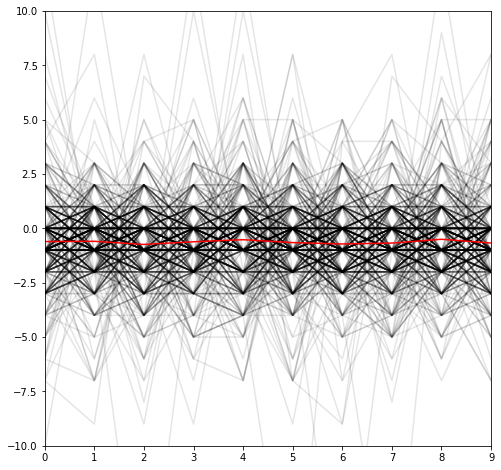

In [0]:
#!pip install tslearn
n = 1
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters = n,verbose=True)
y_pred = km.fit_predict(bads)

#collections.Counter(y_pred)

fig = plt.figure(figsize=(8,8))
for yi in range(n):
    ax = plt.subplot(n, 1, yi + 1)
    for xx in bads[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.10)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 9)
    plt.ylim(-10, 10)
    if yi == 1:
        plt.title("Euclidean $k$-means")
fig.savefig('dowjones_clusters.png')